In [ ]:
!pip install langchain langchain_core langchain_community langgraph langchain_openai

  Using cached langchain-0.3.26-py3-none-any.whl.metadata (7.8 kB)
  Using cached langchain_core-0.3.69-py3-none-any.whl.metadata (5.8 kB)
  Using cached langgraph-0.5.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached langchain_openai-0.3.28-py3-none-any.whl.metadata (2.3 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached sqlalchemy-2.0.41-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using 

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os 
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")


In [4]:
from typing import TypedDict
class State(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str

In [5]:
from langgraph.graph import StateGraph,START,END

workflow  = StateGraph(State)


In [6]:
from langchain_core.prompts import ChatPromptTemplate

In [7]:
def categorize_experience(state: State) -> State:
    print("Experience Categorization")
    prompt = ChatPromptTemplate.from_template("Based on the following application experience,REPLY ONLY WITH THE CATEGORY. categorize it into one of the following categories: 'Entry Level', 'Mid-Level', or 'Senior-level'"
    "Application: {application}  ")
    
    chain = prompt | llm
    experience_level = chain.invoke({"application": state['application']}).content
    print(f"Experience Level: {experience_level}")
    return {"experience_level": experience_level}

def asses_skills(state:State):
    print("Skill Assessment")
    prompt = ChatPromptTemplate.from_template("Based on the job application, assess the skills required for a Python Developer." 
                                              "respond with either 'Match' or 'No Match'"
                                              "Application: {application}")
    
    chain = prompt | llm
    skills_match = chain.invoke({"application": state['application']}).content
    print(f"Skills Match: {skills_match}")
    return {"skill_match": skills_match}

def schedule_interview(state:State)->State:
    print("Interview Scheduling")
    return {"response":"Candidate has been scheduled for an interview"}

def escalate_to_recruiter(state:State)->State:
    print("Escalation to Recruiter")
    return {"response":"The candidate's profile is Senior-level but doesnt match the job skills."}

def reject_application(state:State)->State:
    print("Rejecting Application")
    return {"response":"The candidate does not meet the requirements for this position and has been rejected."}


In [8]:
workflow.add_node("categorize_experience",categorize_experience)

In [9]:
workflow.add_node("asses_skillset",asses_skills)
workflow.add_node("schedule_hr_interview",schedule_interview)
workflow.add_node("escalate_to_recruiter",escalate_to_recruiter)
workflow.add_node('reject_application',reject_application)


In [10]:
def route_app(state:State) -> str:
    if state['skill_match'] == 'Match':
        return 'schedule_hr_interview'
    elif(state['experience_level']=='Senior-level'):
        return 'escalate_to_recruiter'
    else:
        return 'reject_application'


In [11]:
from langgraph.graph import START,END

workflow.add_edge(START,"categorize_experience")
workflow.add_edge("categorize_experience","asses_skillset")
workflow.add_conditional_edges("asses_skillset",route_app,
                                 {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recruiter": "escalate_to_recruiter", 
        "reject_application": "reject_application"
    })
workflow.add_edge("asses_skillset",END)
workflow.add_edge('escalate_to_recruiter',END)
workflow.add_edge('reject_application',END)
workflow.add_edge('schedule_hr_interview',END)



In [12]:
app = workflow.compile()

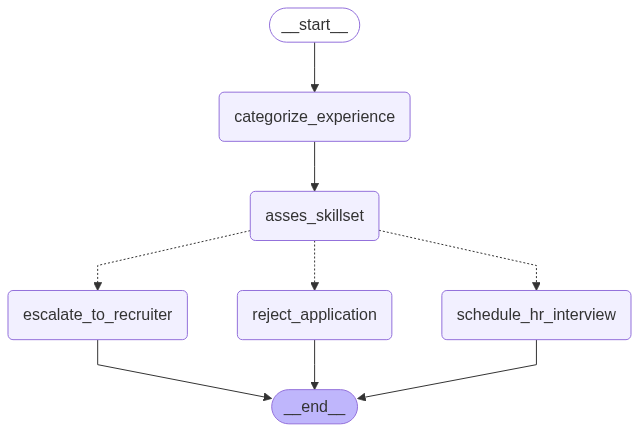

In [13]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
def run_candidate_screening(application:str):
    results = app.invoke({"application": application})
    return {
        "experience_level": results['experience_level'],
        "skill_match": results['skill_match'],
        "response": results['response']
    }

In [17]:
application_text = "I have 5 years of experience in software engineering with expertise in python"

results = run_candidate_screening(application_text)
print("\n Computed results:")
print("Application",application_text)
print("Experience level: ", results['experience_level'])
print("Skill match: ", results['skill_match'])
print("response", results['response'])

Experience Categorization
Experience Level: Mid-Level
Skill Assessment
Skills Match: Match
Interview Scheduling

 Computed results:
Application I have 5 years of experience in software engineering with expertise in python
Experience level:  Mid-Level
Skill match:  Match
response Candidate has been scheduled for an interview
